In [1]:
from util.gen_utils import *
from util.class_def.de_obj_classes import *
from util.plot_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load data
* RNAseq data with TMM normalization
* Metadata
* DE data
    * Both general changes over time in preg
    * PE specific changes over time in preg

In [2]:
rnaseq = rnaseq_data("../../data/rnaseq_discovery_data/htseq_postQC.csv", "../../data/rnaseq_discovery_data/TMM_postQC.csv", mygene_db = mygene.MyGeneInfo())
meta = read_sample_meta_table("../../data/rnaseq_discovery_data/sample_meta_postQC.csv")

de_PE = de_data("out/de/DE_PEspecific_changes_over_gestation.csv", alpha = 0.05, de_type = 'PE preg changes')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7151...done.
Finished.
16 input query terms found no hit:
	['ENSG00000116957', 'ENSG00000133808', 'ENSG00000150076', 'ENSG00000155640', 'ENSG00000199837', 'ENS
querying 1-16...done.
Finished.
8 input query terms found no hit:
	['AL356053.1', 'none', 'none', 'RP11-367G6.3', 'none', 'none', 'none', 'none']


In [3]:
#What kind of genes are DE in PE
rnaseq.anno.loc[de_PE.de.loc[de_PE.is_sig_mask].index].gene_type.value_counts()

protein_coding                        486
processed_pseudogene                   20
lncRNA                                 14
Mt_tRNA                                12
misc_RNA                               12
transcribed_processed_pseudogene        4
transcribed_unprocessed_pseudogene      3
IG_C_gene                               2
snoRNA                                  2
unprocessed_pseudogene                  2
scaRNA                                  1
snRNA                                   1
TR_C_gene                               1
polymorphic_pseudogene                  1
Name: gene_type, dtype: int64

# Understand DE trends over time
* In DE, modeled gestation (time) as natural cubic spline
* To understand when in gestation these changes occured, look at post-hoc logFC calculations

In [4]:
sig_genes = de_PE.de.index[de_PE.is_sig_mask]
term_logFC_sig = logFC_data_by_group(sig_genes, term_labels, CV_cutoff = 0.45)
term_logFC_sig.get_logFC_and_CI_by_group(rnaseq.logCPM.loc[sig_genes, :], meta)

Now calculating logFC for Early gestation
Now calculating logFC for Mid-gestation
Now calculating logFC for Late gestation
Now calculating logFC for Post-partum
Now estimating logFC confidence interval for Early gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Mid-gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Late gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Post-partum
1000 resampling iterations completed
2000 resampling iterations completed
Identifying when during gestation we observe changes


# How do PE specific changes look over time in general
* What is the spread of logFC by time group
* Visualize DEGs where FC remains consistent based on 95% CI delta and CV at each time point
    * Defined consistent as logFC > 0 and CV(logFC) <= 0.5 (i.e., logFC varies by no more than half its average value for 95% of its plausible range)
    * Note we are only interested in one-sided uncertainty (that which approaches 0) since it matters less when some bootstrapped set yields more extreme logFC

Text(0, 0.5, '$log_2$(Fold change)')

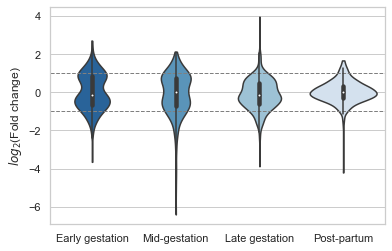

In [5]:
#PE specific
fig, ax = plt.subplots()
plt.hlines([-1, 1], -1, 4, lw = 1, linestyle = 'dashed', color = 'gray')
sns.violinplot(x = 'variable', y = 'value', data = term_logFC_sig.logFC.iloc[:, :4].melt(), palette = 'Blues_r', inner = 'box', cut = 0)

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
plt.xlabel("") 
plt.ylabel(r"$log_2$(Fold change)")

Early gestation: 4 genes have CV greater than cutoff
Mid-gestation: 3 genes have CV greater than cutoff
Late gestation: 9 genes have CV greater than cutoff
Post-partum: 8 genes have CV greater than cutoff


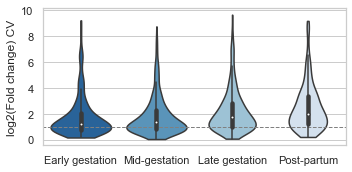

In [6]:
melted_CI_frac = term_logFC_sig.CV.melt().dropna()
cutoff = 10

for time_pt in term_labels.values():
    print('%s: %d genes have CV greater than cutoff' % (time_pt, np.sum(melted_CI_frac.loc[melted_CI_frac.variable == time_pt, "value"] > cutoff)))

fig, ax = plt.subplots(1, figsize = (5, 2.5))

plt.hlines([1], -1, 4, lw = 1, linestyle = 'dashed', color = 'gray')
sns.violinplot(x = 'variable', y = 'value', inner = 'box', cut = 0, 
               data = melted_CI_frac.loc[melted_CI_frac.value <= cutoff], ax = ax, palette = 'Blues_r')

#Fix axes and legend
plt.xlabel("")
plt.ylabel("log2(Fold change) CV")
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

fig.tight_layout()

In [7]:
np.round((np.sum(term_logFC_sig.CV <= 1) / term_logFC_sig.CV.shape[0]), 2)

Early gestation    0.36
Mid-gestation      0.34
Late gestation     0.22
Post-partum        0.14
dtype: float64

# PE specific DEG clustering
* See if these DEGs cluster PE vs normotensive at each time point

Early gestation: N DE genes used = 33, N samples = 25
Mid-gestation: N DE genes used = 25, N samples = 29
Late gestation: N DE genes used = 12, N samples = 31
Post-partum: N DE genes used = 14, N samples = 30


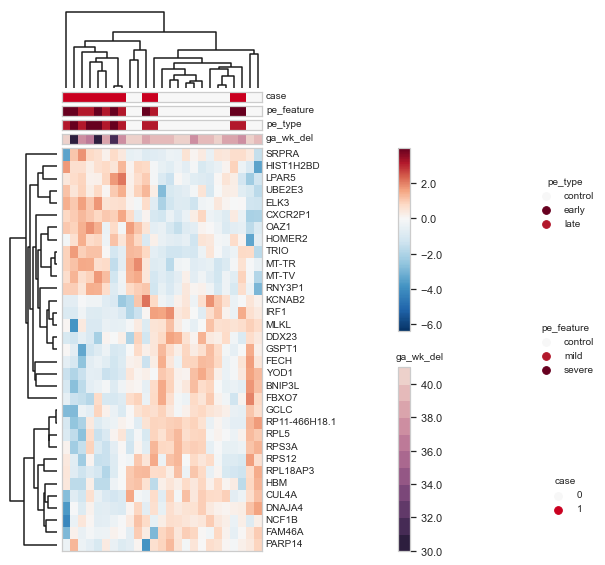

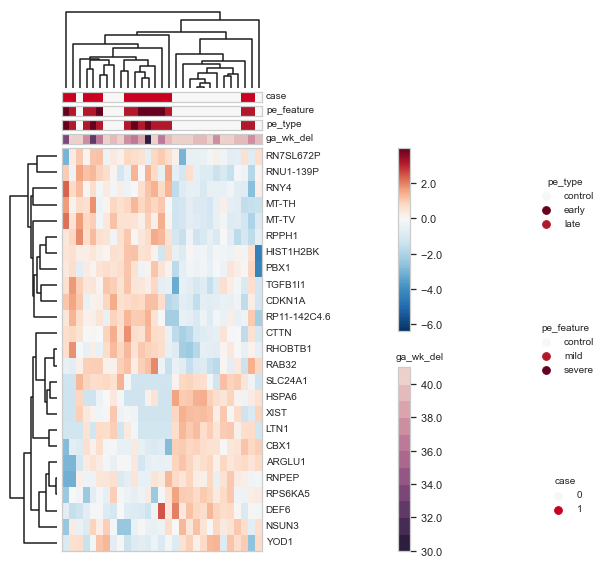

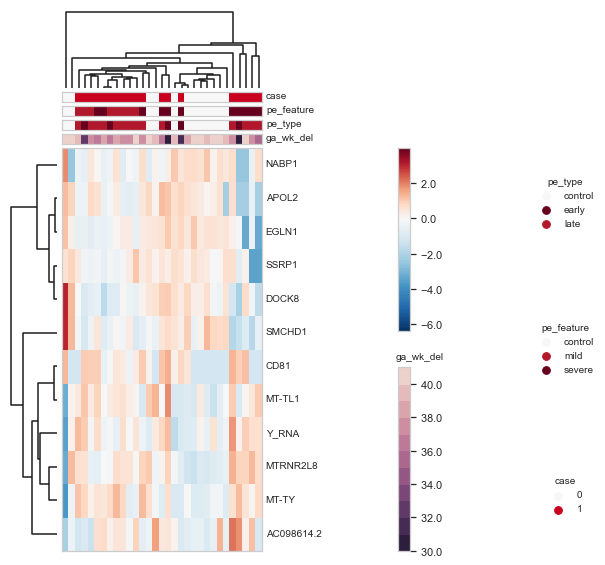

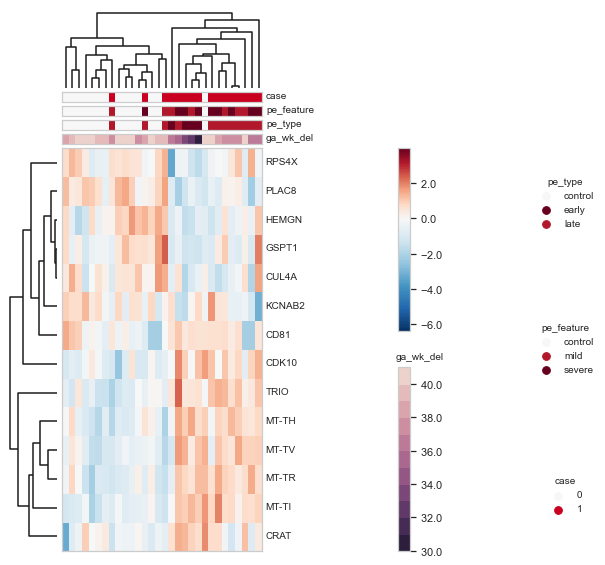

In [8]:
cmaps = {"case" : make_color_map("", ['#f7f7f7', '#ca0020']),
         'pe_feature' : make_color_map("", pe_feat_palette),
        "pe_type" : make_color_map("", pe_type_palette),
        "ga_wk_del" : make_color_map("", sns.cubehelix_palette(len(meta.ga_wk_del.unique()), reverse = True).as_hex())}

logFC_cutoff = np.log2(1)                                    
zscore_cbar_params = {'min' : np.min(term_logFC_sig.logFC.to_numpy()), 
                      'mid' : 0, 
                      'max' : np.max(term_logFC_sig.logFC.to_numpy())} #So that color bar is consistent across figures 
pe_sig_terms = {}

for term, term_label in term_labels.items():
    pass_logFC_and_CV_mask = np.logical_and(np.abs(term_logFC_sig.logFC.loc[:, term_label]) >= logFC_cutoff, term_logFC_sig.CV_mask.loc[:, term_label])
    pe_sig_terms[term_label] = sig_genes[pass_logFC_and_CV_mask]
    
    meta_term = meta.loc[meta.term == term].drop_duplicates(subset = ['subject'], keep = 'first')
    meta_term.loc[:, 'subject'] = meta_term.subject.astype(str)
    meta_term.loc[:, 'case'] = meta_term.case.astype(str)
    
    scaled_logCPM_to_plot = pd.DataFrame(scipy.stats.zscore(rnaseq.logCPM.loc[pe_sig_terms[term_label], meta_term.index], axis = 1), 
                                         index = rnaseq.logCPM.loc[pe_sig_terms[term_label]].index.droplevel('gene_num'), 
                                         columns = meta_term.subject
                                        )
    meta_term = meta_term.reset_index(drop = True).set_index('subject').loc[:, list(cmaps.keys())]
    
    print("%s: N DE genes used = %d, N samples = %s" % (term_label, scaled_logCPM_to_plot.shape[0], meta_term.shape[0]))
    fig, _ = nhm_plot_heatmap(scaled_logCPM_to_plot, dfc = meta_term, cmaps = cmaps, center_args = zscore_cbar_params)

N DE genes used = 33, N samples = 29
N DE genes used = 33, N samples = 31
N DE genes used = 33, N samples = 30
N DE genes used = 25, N samples = 25
N DE genes used = 25, N samples = 31
N DE genes used = 25, N samples = 30
N DE genes used = 12, N samples = 25
N DE genes used = 12, N samples = 29
N DE genes used = 12, N samples = 30
N DE genes used = 14, N samples = 25
N DE genes used = 14, N samples = 29
N DE genes used = 14, N samples = 31


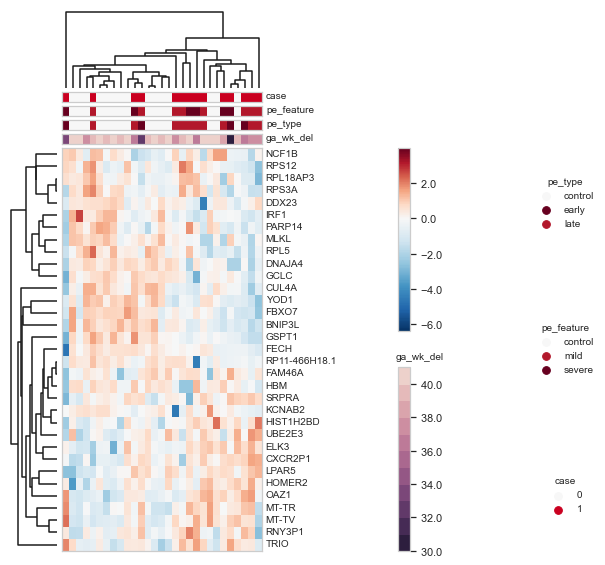

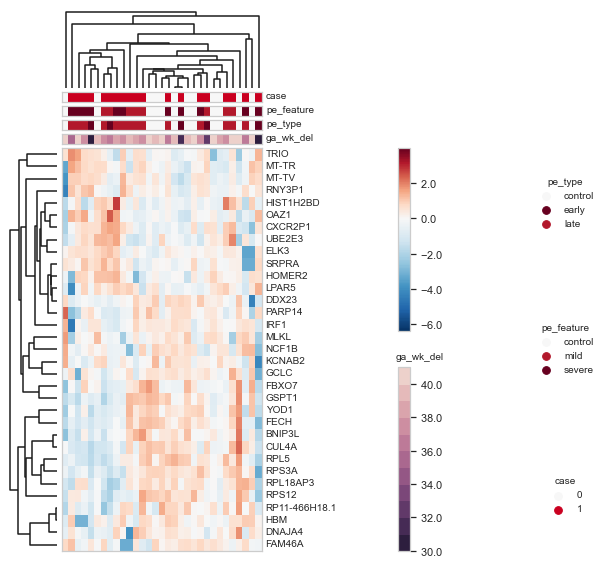

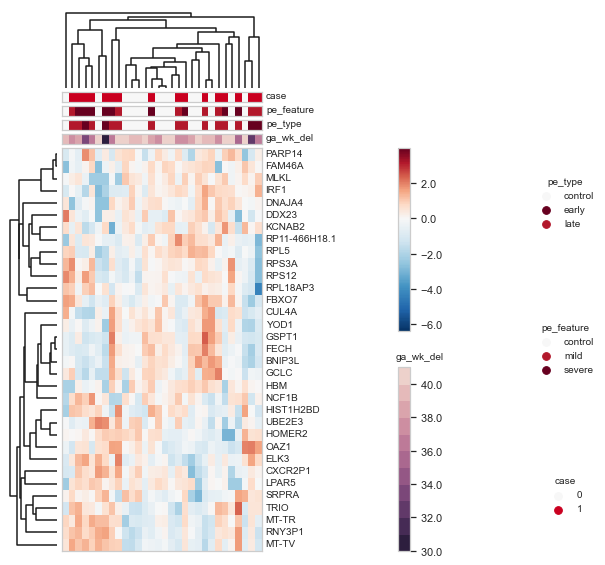

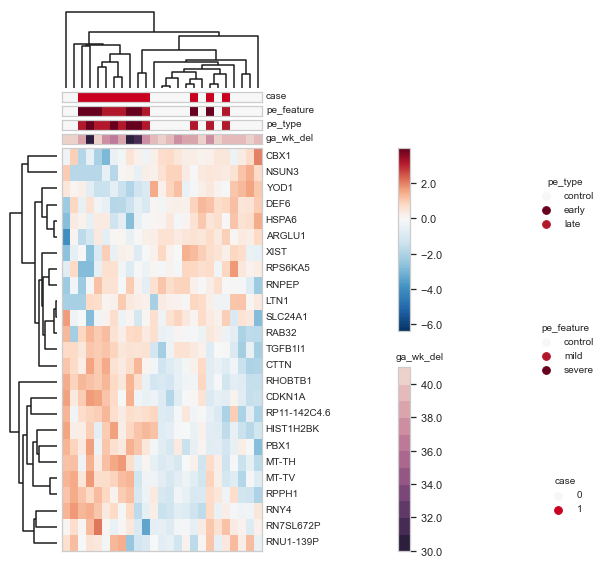

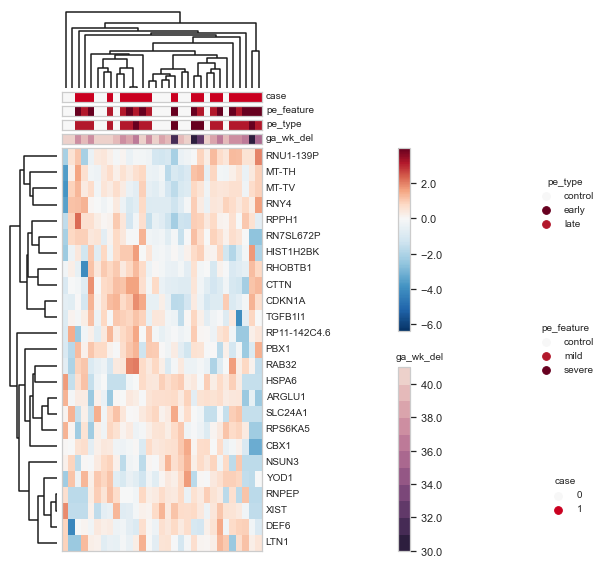

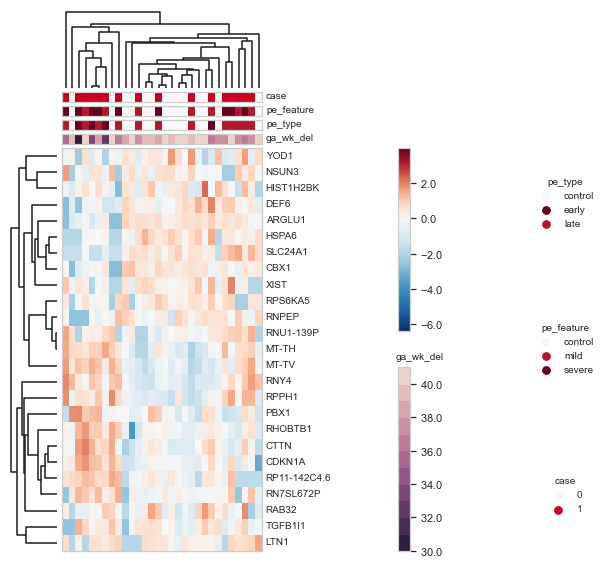

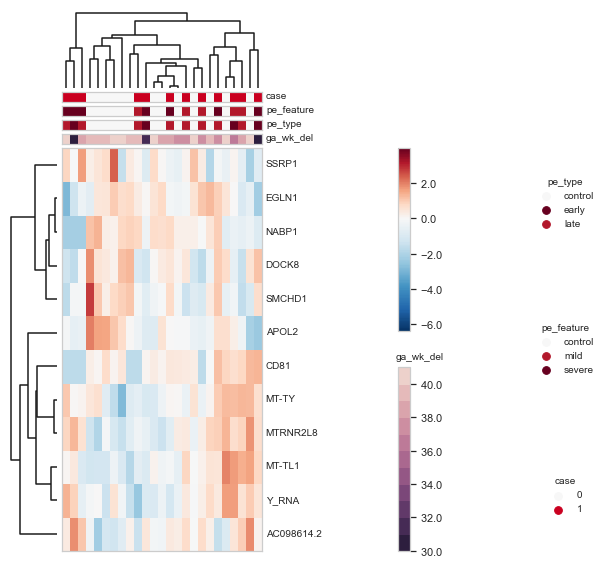

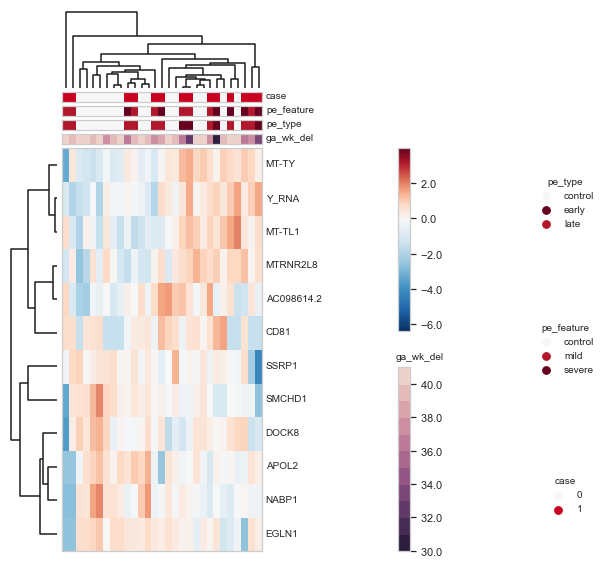

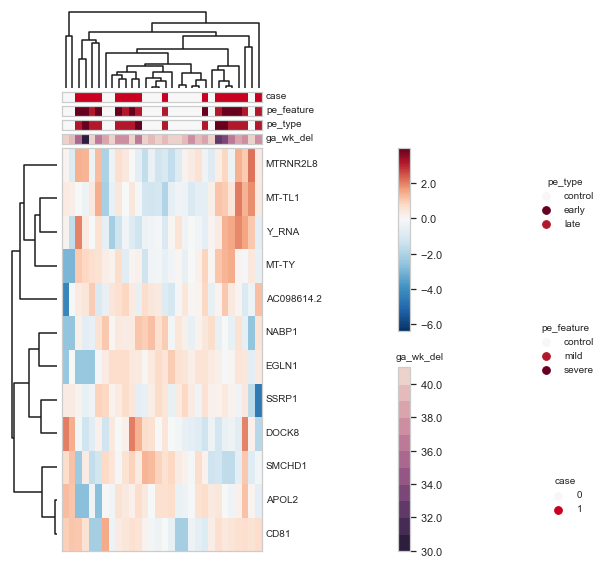

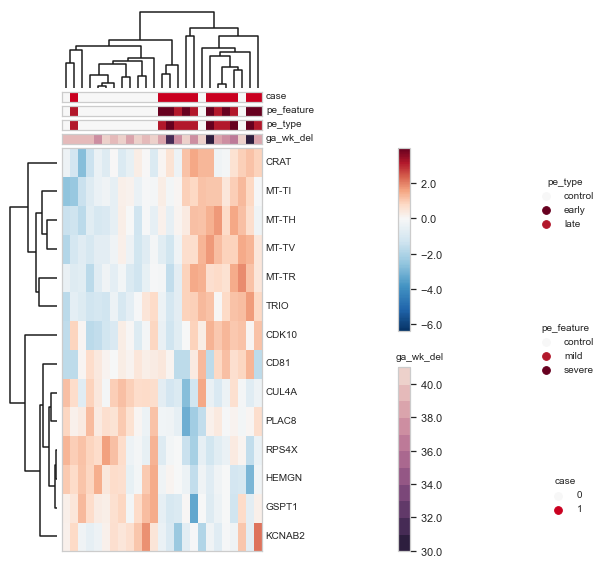

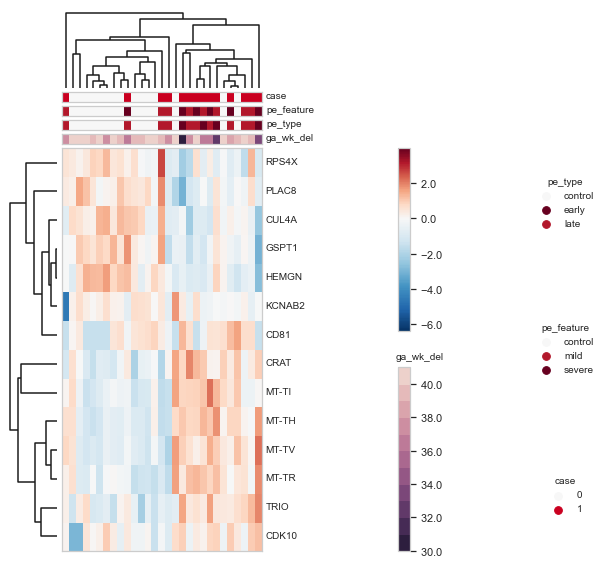

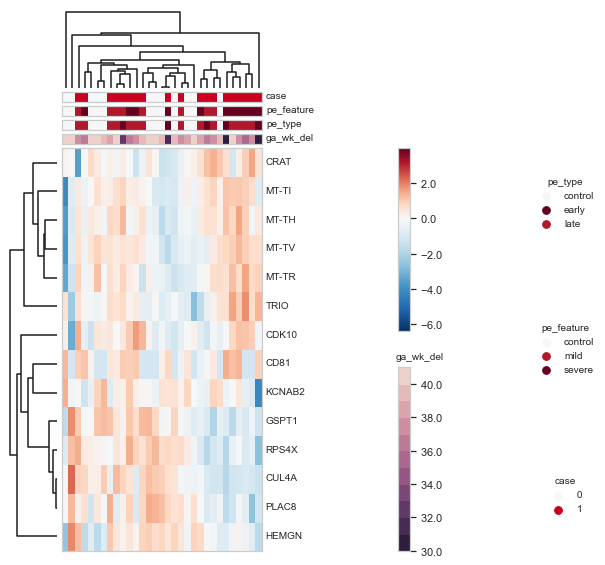

In [9]:
#For supplement
#See if genes from 1 term can cluster samples from other terms
for term, term_label in term_labels.items():
    for other_term in term_labels.keys():
        if other_term == term:
            continue
        meta_term = meta.loc[meta.term == other_term].drop_duplicates(subset = ['subject'], keep = 'first')
        meta_term.loc[:, 'case'] = meta_term.case.astype(str)

        scaled_logCPM_to_plot = pd.DataFrame(scipy.stats.zscore(rnaseq.logCPM.loc[pe_sig_terms[term_labels[term]], meta_term.index], axis = 1), 
                                             index = rnaseq.logCPM.loc[pe_sig_terms[term_labels[term]]].index.droplevel('gene_num'), 
                                             columns = meta_term.subject
                                            )
        meta_term = meta_term.reset_index(drop = True).set_index('subject').loc[:, list(cmaps.keys())]

        print("N DE genes used = %d, N samples = %s" % (scaled_logCPM_to_plot.shape[0], meta_term.shape[0]))
        nhm_plot_heatmap(scaled_logCPM_to_plot, dfc = meta_term, cmaps = cmaps, center_args = zscore_cbar_params)

# K-means cluster
* Understand time trends

Identified 3 logFC trends over time
N genes per cluster
2    266
1    235
3     60
Name: kmeans_cluster, dtype: int64


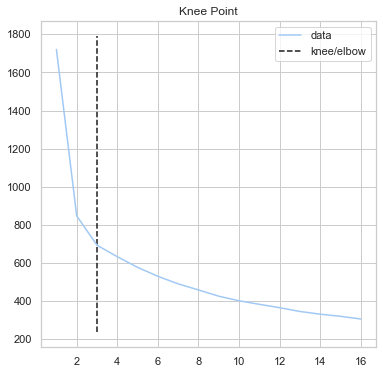

In [10]:
sum_sq_dist = []

n_max_clusters = 4**2 #4 time points with 2 possibiliites at each (DE or not)
seed = 37
for k in np.arange(1, (n_max_clusters + 1)):
    model = cluster.KMeans(n_clusters = k, random_state = seed).fit(term_logFC_sig.logFC)
    sum_sq_dist.append(model.inertia_)
    
kneedle = KneeLocator(np.arange(1,(n_max_clusters + 1)), sum_sq_dist, S = 1.0, curve = 'convex', direction = 'decreasing')
kneedle.plot_knee() #Just to visually confirm things look good
print('Identified %d logFC trends over time' % kneedle.elbow)

final_model = cluster.KMeans(n_clusters = kneedle.elbow, random_state = seed).fit(term_logFC_sig.logFC)
term_logFC_sig.logFC.insert(0, 'kmeans_cluster', (final_model.predict(term_logFC_sig.logFC) + 1))
print('N genes per cluster')
print(term_logFC_sig.logFC.kmeans_cluster.value_counts())

In [11]:
print(np.round(term_logFC_sig.logFC.kmeans_cluster.value_counts() / term_logFC_sig.logFC.shape[0], 2))

2    0.47
1    0.42
3    0.11
Name: kmeans_cluster, dtype: float64


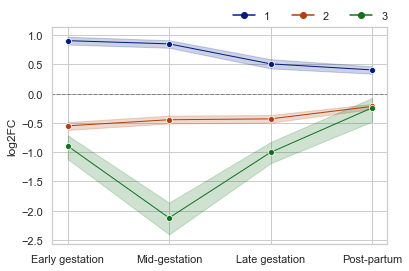

In [12]:
fig, ax = plt.subplots()

plt.hlines(0, -1, 5, linestyle = 'dashed', color = 'gray', lw = 1)

sns.lineplot(x = 'variable', y = 'value', hue = 'kmeans_cluster', style = 'kmeans_cluster', 
             data = term_logFC_sig.logFC.melt(id_vars='kmeans_cluster'),
             sort = False, seed = seed, ci = 95, n_boot = 1000, lw = 1, palette = 'dark',
             markers = {cluster_i : 'o' for cluster_i in np.arange(1, kneedle.elbow + 1)}, dashes = False)

plt.xlabel("")
plt.ylabel("log2FC")

h,l = ax.get_legend_handles_labels()
plt.legend(h[1:], l[1:], ncol = 3, frameon=0, bbox_to_anchor=(1.03, 1.12)) #[1, :] removes legend title

# GO Analysis

In [13]:
go_queries = {'kmeans' : {}}

#Get GO queries - 1 per kmeans cluster
for kmeans_cluster in sorted(term_logFC_sig.logFC.kmeans_cluster.unique()):
    lfc_cluster = term_logFC_sig.logFC.loc[term_logFC_sig.logFC.kmeans_cluster == kmeans_cluster]
    go_queries['kmeans'][str(kmeans_cluster)] = lfc_cluster.index.get_level_values(1).to_list()

In [14]:
#Get GO table
#For IEA definition - see https://biit.cs.ut.ee/gprofiler/page/docs#electronic_annotations_iea
go_tables_og = {key : GProfiler(return_dataframe = True).profile(organism = 'hsapiens', sources = ["GO:MF","GO:BP","KEGG","REAC","TF","HPA", "HP"],
                                                      domain_scope = 'annotated', no_evidences = False, no_iea = False,
                                                      query = queries).sort_values(by = ['query','source'])
             for key, queries in go_queries.items()}

go_tables = go_tables_og.copy()
for query, go_table in go_tables.items():
    print('GO table using %s queries has %d terms' % (query, go_table.shape[0]))

GO table using kmeans queries has 487 terms


In [15]:
for key, go_table in go_tables_og.items():
    ordered_idx = go_table.index.to_numpy() #Order table such that terms go child -> parent
    ordered_idx_only_parents = go_table.index.to_numpy() #kmeans GO terms are too many to include in plot so only plot parent terms for interpretability

    for group, go_grouped in go_table.groupby('query'):
        #Cannot use sort values since lists are not hashable
        is_parent = [go_grouped.native.isin(parent_list) for parent_list in go_grouped.parents] #True = parent
        
        child_i = -1
        for elem in is_parent:
            child_i += 1
            if np.sum(elem) == 0: #All false
                continue
            child_idx = go_grouped.iloc[child_i].name
            parent_idx = go_grouped[elem].index.to_numpy()

            ordered_idx = ordered_idx[~np.isin(ordered_idx, parent_idx)] #Choose all elem except parents            
            child_iloc = np.where((child_idx == ordered_idx))[0][0]
            ordered_idx = np.concatenate((ordered_idx[: (child_iloc + 1)], parent_idx, ordered_idx[(child_iloc + 1):]), axis = 0)

            ordered_idx_only_parents = ordered_idx_only_parents[~np.isin(ordered_idx_only_parents, child_idx)] #Choose all elem except child
    
    if key == 'logFC':
        go_table = go_table.loc[ordered_idx]
    
    if key == 'kmeans':
        go_table = go_table.loc[ordered_idx_only_parents]
        
    go_table['query'] = DE_plot_order(go_table['query'], key)
    go_table.sort_values(by = ['query', 'source'], inplace = True)
    go_tables[key] = go_table
    
    print('GO table using %s queries has %d terms after pruning' % (key, go_table.shape[0]))
    
go_tables['kmeans'].head()

GO table using kmeans queries has 173 terms after pruning


,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
223,GO:BP,GO:0001775,cell activation,0.000096,True,"""A change in the morphology or behavior of a c...",1510,177,38,18092,0.214689,0.025166,1,[GO:0009987],"[ENSG00000169704, ENSG00000101335, ENSG0000018...","[[TAS], [HMP], [TAS], [IEA], [IEA], [IBA], [IE..."
346,GO:BP,GO:0030029,actin filament-based process,0.003418,True,"""Any cellular process that depends upon or alt...",824,177,24,18092,0.135593,0.029126,1,[GO:0009987],"[ENSG00000186575, ENSG00000130429, ENSG0000006...","[[IMP], [IDA, IBA, IEA], [IDA, ISS, IBA], [IMP..."
366,GO:BP,GO:0007166,cell surface receptor signaling pathway,0.005786,True,"""A series of molecular signals initiated by ac...",3242,177,57,18092,0.322034,0.017582,1,[GO:0007165],"[ENSG00000038382, ENSG00000172819, ENSG0000021...","[[TAS], [TAS], [ISS, IEA], [IDA, IBA, IEA], [I..."
377,GO:BP,GO:0009611,response to wounding,0.006840,True,"""Any process that results in a change in state...",682,177,21,18092,0.118644,0.030792,1,[GO:0006950],"[ENSG00000169704, ENSG00000101335, ENSG0000017...","[[TAS, IEA], [HMP], [IDA, IMP], [IEA], [ISS, I..."
378,GO:BP,GO:0097581,lamellipodium organization,0.007189,True,"""A process that is carried out at the cellular...",93,177,8,18092,0.045198,0.086022,1,[GO:0120036],"[ENSG00000198753, ENSG00000132613, ENSG0000006...","[[ISS, IEA], [IEA], [IMP, ISS], [ISS], [IMP, I..."


In [22]:
go_tables['kmeans'].loc[go_tables['kmeans'].source == 'HPA']

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,intersections,evidences
364,HPA,HPA:0340463,ovary; ovarian stroma cells[High],5.570118e-03,True,ovary; ovarian stroma cells[High],347,136,15,10596,0.110294,0.043228,1,[HPA:0340462],"[ENSG00000158373, ENSG00000185630, ENSG0000020...","[[Supported], [Supported], [Approved], [Suppor..."
0,HPA,HPA:0310000,lymph node,4.832715e-18,True,lymph node,6333,178,161,10596,0.904494,0.025422,2,[HPA:0000000],"[ENSG00000162735, ENSG00000116754, ENSG0000016...","[[Supported], [Supported], [Supported], [Appro..."
4,HPA,HPA:0530000,spleen,4.516157e-15,True,spleen,5716,178,149,10596,0.837079,0.026067,2,[HPA:0000000],"[ENSG00000162735, ENSG00000116754, ENSG0000016...","[[Supported], [Supported], [Supported], [Appro..."
11,HPA,HPA:0600000,tonsil,1.028791e-13,True,tonsil,7557,178,169,10596,0.949438,0.022363,2,[HPA:0000000],"[ENSG00000125347, ENSG00000175467, ENSG0000016...","[[Supported], [Supported], [Supported], [Suppo..."
18,HPA,HPA:0030000,appendix,3.156884e-13,True,appendix,7514,178,168,10596,0.943820,0.022358,2,[HPA:0000000],"[ENSG00000125347, ENSG00000175467, ENSG0000016...","[[Supported], [Supported], [Supported], [Enhan..."
53,HPA,HPA:0460000,skin 1,1.593421e-10,True,skin 1,6881,178,157,10596,0.882022,0.022816,2,[HPA:0000000],"[ENSG00000125347, ENSG00000175467, ENSG0000016...","[[Supported], [Supported], [Supported], [Appro..."
65,HPA,HPA:0040000,bone marrow,8.331045e-10,True,bone marrow,6290,178,148,10596,0.831461,0.023529,2,[HPA:0000000],"[ENSG00000125347, ENSG00000162735, ENSG0000011...","[[Supported], [Supported], [Supported], [Suppo..."
74,HPA,HPA:0300000,lung,2.580866e-09,True,lung,7124,178,158,10596,0.887640,0.022179,2,[HPA:0000000],"[ENSG00000125347, ENSG00000162735, ENSG0000008...","[[Supported], [Supported], [Approved], [Enhanc..."
84,HPA,HPA:0610000,urinary bladder,2.116170e-08,True,urinary bladder,7092,178,156,10596,0.876404,0.021997,2,[HPA:0000000],"[ENSG00000125347, ENSG00000175467, ENSG0000016...","[[Supported], [Supported], [Supported], [Suppo..."
85,HPA,HPA:0350000,pancreas,2.174013e-08,True,pancreas,7173,178,157,10596,0.882022,0.021888,2,[HPA:0000000],"[ENSG00000125347, ENSG00000175467, ENSG0000016...","[[Supported], [Supported], [Supported], [Appro..."


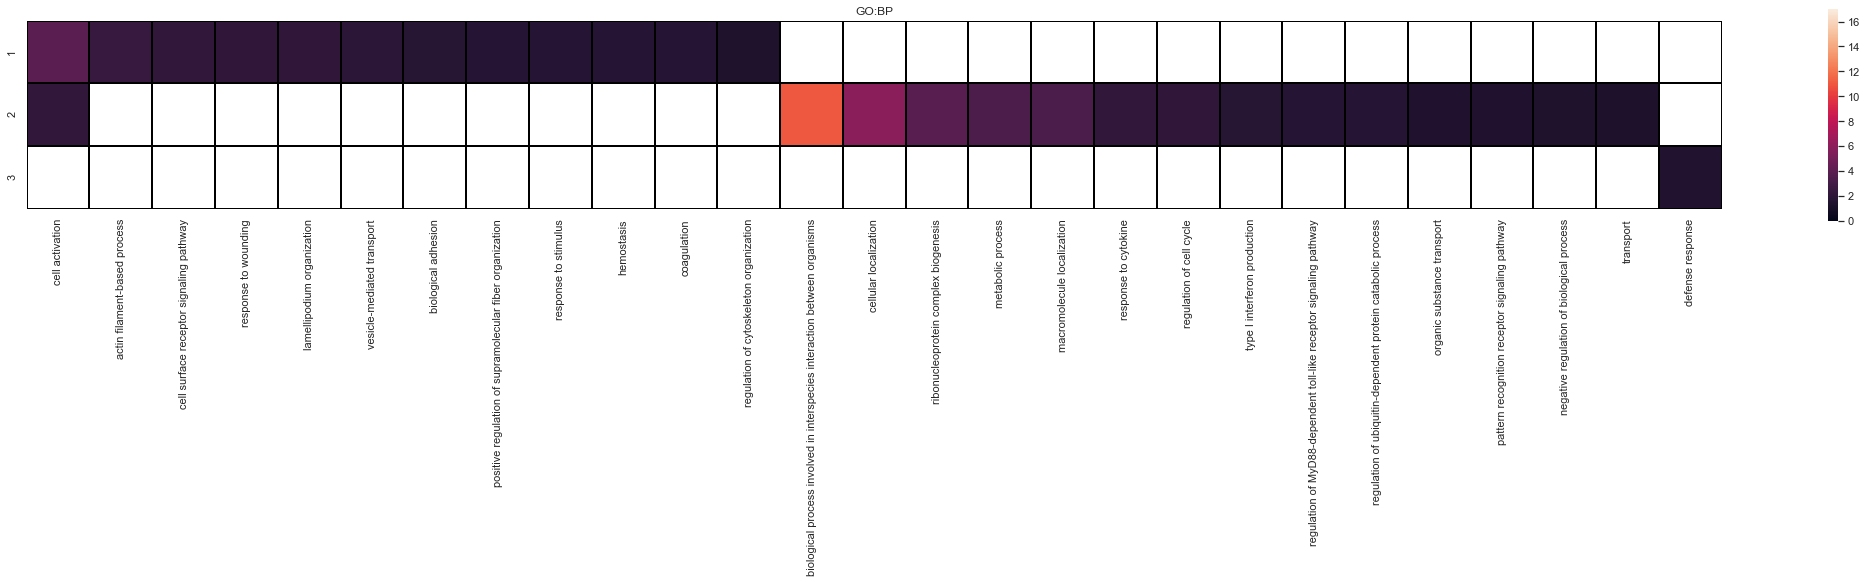

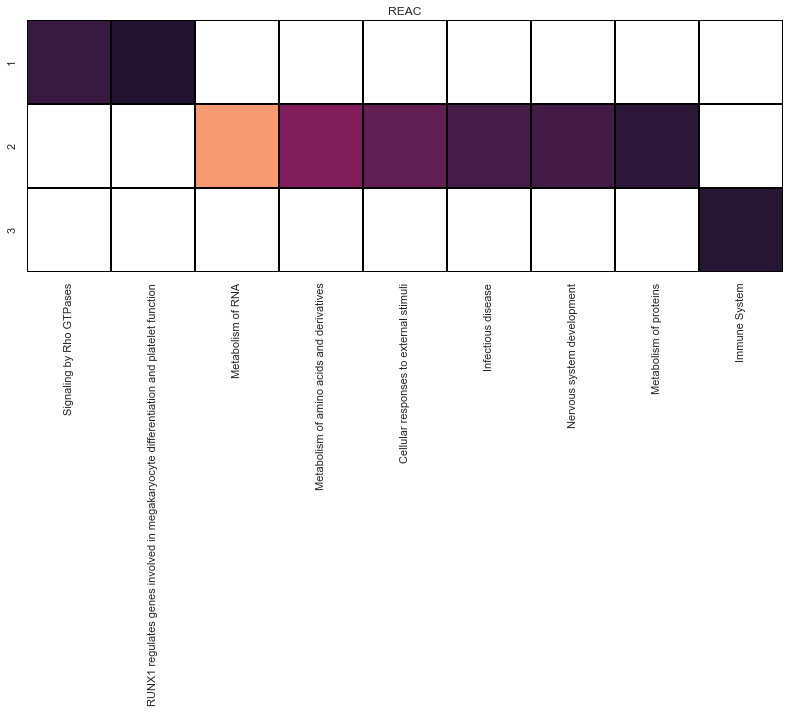

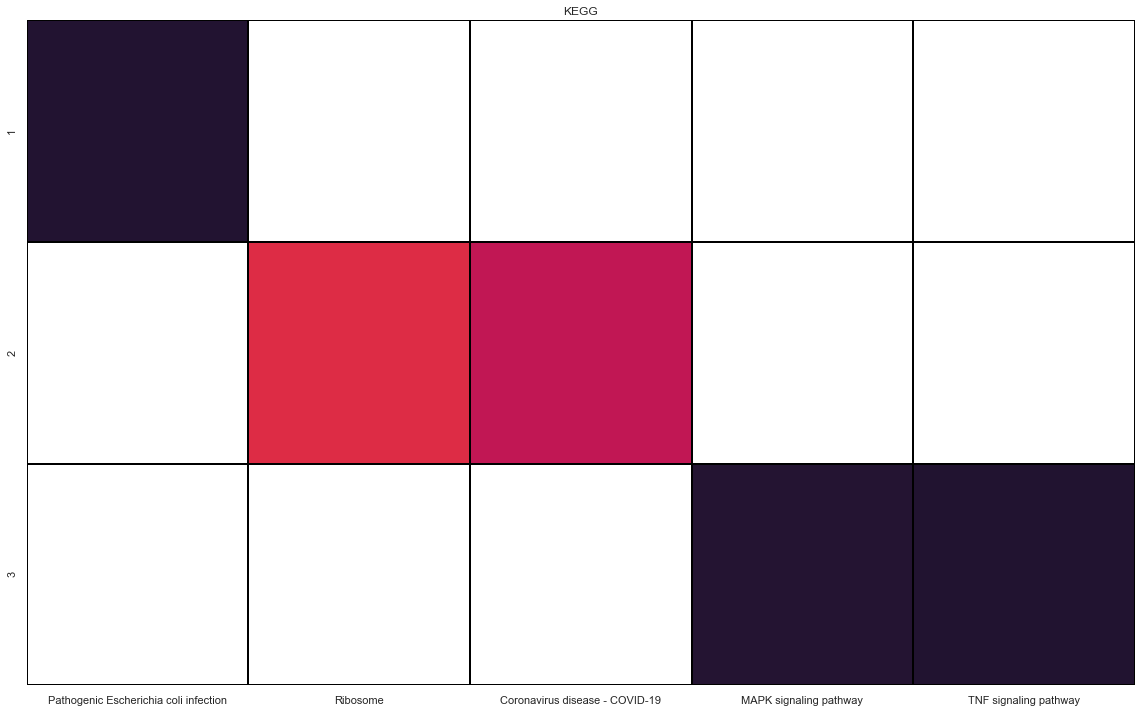

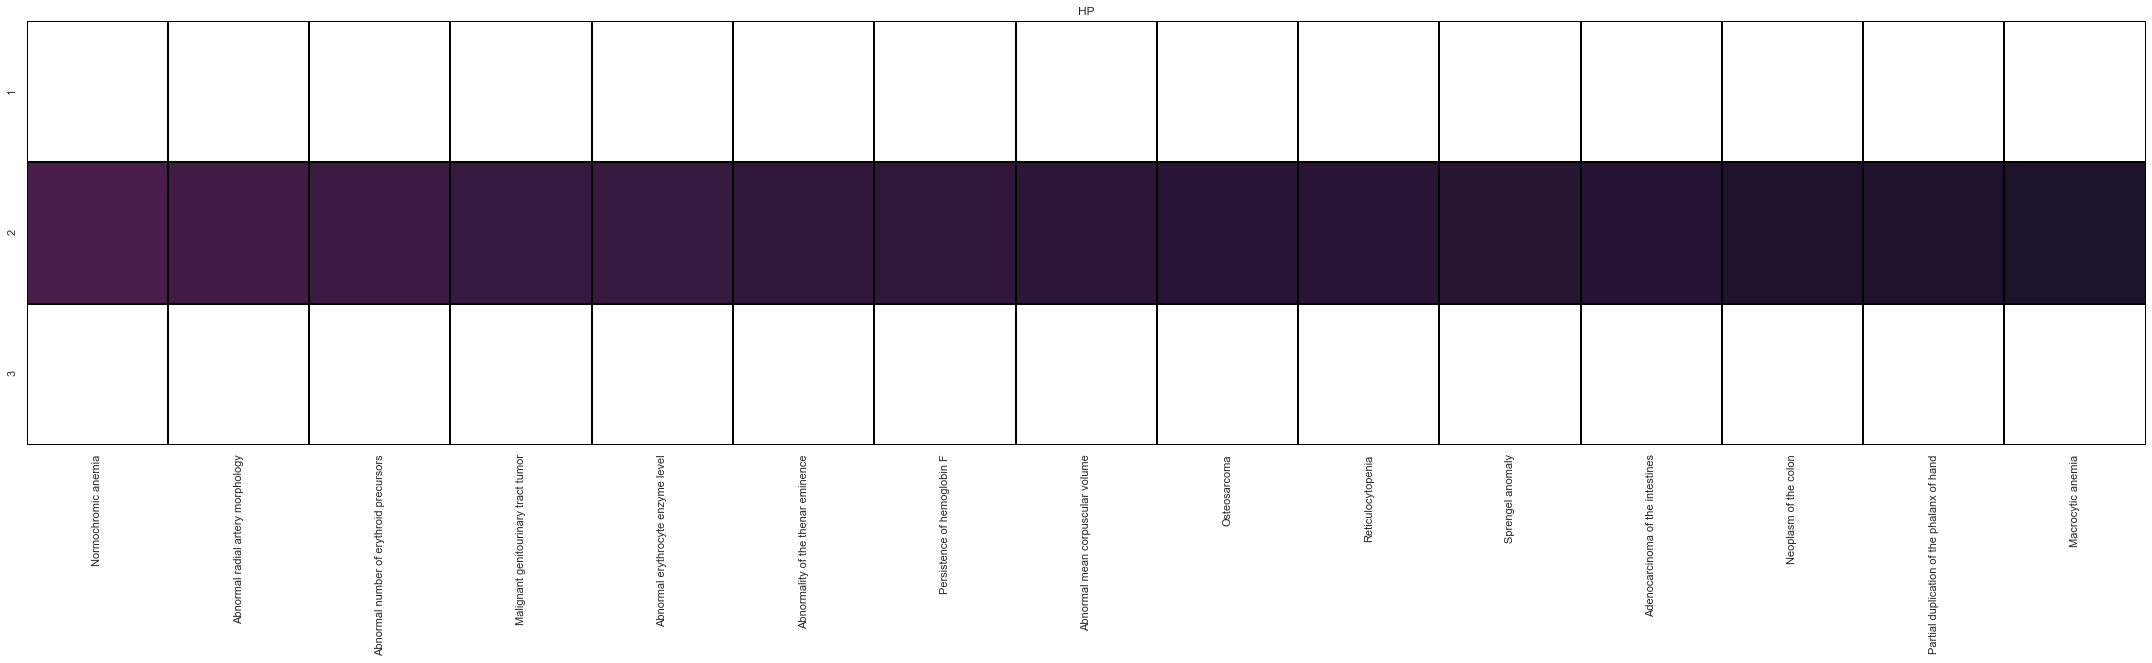

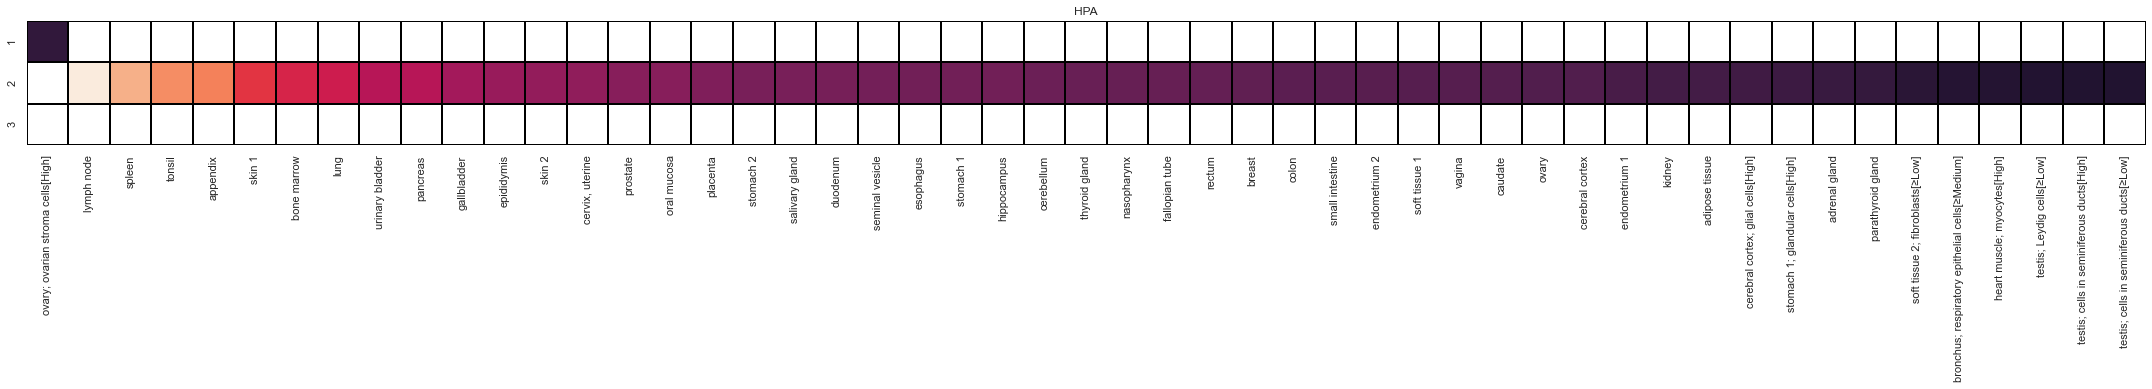

In [16]:
sources_to_include = ['GO:BP', 'REAC', 'KEGG', 'HP', 'HPA'] #"HPA", "GO:MF", "TF", "MIRNA"]

plot_colorbar = True

for source in sources_to_include:
    for query_type, go_table in go_tables.items():
        if go_table.loc[go_table.source.isin([source])].shape[0] == 0:
            continue
        
        go_table_to_plot = -1*np.log10(go_table.loc[go_table.source.isin([source]), ['name', 'query', 'p_value']].pivot(index = 'query', columns = 'name', values = 'p_value')).fillna(0)
        go_table_to_plot = go_table_to_plot.loc[:, go_table.loc[go_table.source.isin([source])].name]
        go_table_to_plot = go_table_to_plot.loc[:, ~go_table_to_plot.columns.duplicated()]

        #Insert keys that did not have any sig GO terms
        for key in go_table_to_plot.index.categories:
            if key in go_table_to_plot.index:
                continue
            go_table_to_plot.loc[key, :] = 0
        go_table_to_plot.sort_index(inplace = True)

        fig, ax = plt.subplots(1, figsize = (30, 10))
        sns.heatmap(go_table_to_plot, 
                    mask = (go_table_to_plot == 0),
                    square = True, xticklabels = True, yticklabels = True, linewidths = 1, cmap = 'rocket', linecolor = 'black',
                    cbar_kws={"shrink": 0.4}, vmin = 0, vmax = np.round(np.max(-1*np.log10(go_table.p_value.to_numpy()))), 
                    cbar = plot_colorbar, ax = ax)
            
        plt.title(source)
        plt.xlabel('')
        plt.ylabel('')

        fig.tight_layout()
    plot_colorbar = False
    

# Validation
* Do same logFC hold in separate dataset

In [65]:
val_rnaseq = rnaseq_data("../../data/rnaseq_validation_data/htseq_postQC.csv", "../../data/rnaseq_validation_data/TMM_postQC.csv", mygene_db = mygene.MyGeneInfo())
val_meta = read_sample_meta_table("../../data/rnaseq_validation_data/sample_meta_postQC.csv")

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5199...done.
Finished.
14 input query terms found no hit:
	['ENSG00000133808', 'ENSG00000155640', 'ENSG00000213846', 'ENSG00000265764', 'ENSG00000272053', 'ENS
querying 1-14...done.
Finished.
9 input query terms found no hit:
	['none', 'none', 'RP11-367G6.3', 'none', 'none', 'none', 'none', 'none', 'none']


In [77]:
val_de = val_rnaseq.logCPM.reindex(DE['PE preg changes']['sig_genes']).dropna().index
val_term_logFC = logFC_data_by_group(val_de, term_labels, CV_cutoff = 0.45)
val_term_logFC.get_logFC_and_CI_by_group(val_rnaseq.logCPM.loc[val_de, :], val_meta)

Now calculating logFC for Early gestation
Now calculating logFC for Mid-gestation
Now calculating logFC for Late gestation
Now calculating logFC for Post-partum
Now estimating logFC confidence interval for Early gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Mid-gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Late gestation
1000 resampling iterations completed
2000 resampling iterations completed
Now estimating logFC confidence interval for Post-partum
1000 resampling iterations completed
2000 resampling iterations completed
Identifying when during gestation we observe changes


                               Early gestation  Early gestation
gene_name     gene_num                                         
TRIO          ENSG00000038382             3.02             0.45
SP110         ENSG00000135899             3.26             0.35
IRF1          ENSG00000125347             0.78             0.43
YOD1          ENSG00000180667             1.15             0.44
LPAR5         ENSG00000184574             1.42             0.35
RP11-466H18.1 ENSG00000244398             7.27             0.28
MT-TR         ENSG00000210174             0.58             0.44
FBXO7         ENSG00000100225             0.71             0.23
RPL13AP5      ENSG00000236552             9.28             0.43
MLKL          ENSG00000168404             1.74             0.43
NCF1B         ENSG00000182487             0.77             0.30
SMIM3         ENSG00000256235             1.26             0.44
BNIP3L        ENSG00000104765             0.91             0.33
HIST1H2BD     ENSG00000158373           

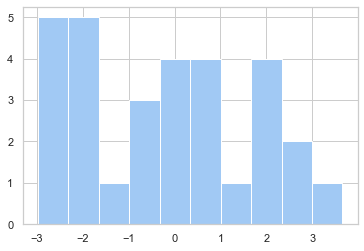

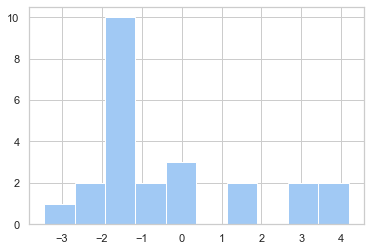

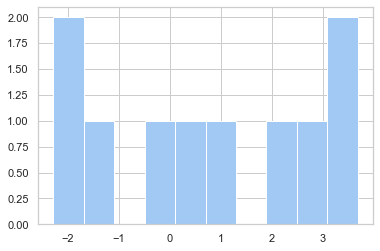

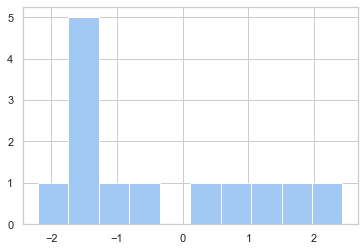

In [96]:
for term, term_label in term_labels.items():
    genes = val_term_logFC.logFC.reindex(pe_sig_terms[term_label]).dropna().index
    delta = val_term_logFC.logFC.loc[genes, term_label] - DE['PE preg changes']['term_logFC'].logFC.loc[genes, term_label]
    print(pd.concat((val_term_logFC.CV.loc[genes, term_label], DE['PE preg changes']['term_logFC'].CV.loc[genes, term_label]), axis = 1))
    sign = np.sign(val_term_logFC.logFC.loc[genes, term_label]) == np.sign(DE['PE preg changes']['term_logFC'].logFC.loc[genes, term_label])
    print(np.sum(sign))
    plt.figure()
    plt.hist(delta)

In [122]:
val_term_logFC.logFC.loc['RPL35']

,Early gestation,Mid-gestation,Late gestation,Post-partum
gene_num,,,,
ENSG00000136942,-0.5876,-0.8833,-0.1192,0.518
